In [46]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from scipy.ndimage import gaussian_filter1d
import os
import pandas as pd
from math import isnan
import random
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci/results'
else:
    resPath = '/results'
    print('Forgot the SSD!!!!!')

In [81]:
def search_time_useStatDif(time, evo, statVal: float, statTime: float):
    evo_dif_to_stat = abs(evo - statVal)
    avgdif = np.average(evo_dif_to_stat[time >= statTime])
    times_below_avgdif = time[evo_dif_to_stat < avgdif]
    if len(times_below_avgdif) > 3:
        max_times_to_use = 3
    else:
        max_times_to_use = len(times_below_avgdif)
    tss = np.average(times_below_avgdif[0:max_times_to_use])
    return tss


def get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime=100.0, Nrea=100, execSim=False):
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
    if execSim: # mandatory to execute simulations, even if evos folder already exists
        pichainExec = ','.join([str(pi) for pi in pis])
        qchainExec = ','.join([str(q) for q in qs])
        ci_kwargs_chainExec = ','.join([str(cikw) for cikw in ci_kwargs])
        simCall = f'python LES_model_gill.py -pis {pichainExec} -qs {qchainExec} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chainExec} '
        simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} --time_evo'
        call(simCall, shell=True)
        call('tar -xzf sim_results_evos.tar.gz', shell=True)
        call(f'mv sim_results_evos {evoName}', shell=True)
        # before moving, chech if directory already exists and if so remove it:
        if os.path.exists(f'{resPath}/{evoName}'):
            call(f'rm -r {resPath}/{evoName}', shell=True)
        # input('enter ')
        call(f'mv {evoName} {resPath}/', shell=True)
    if os.path.exists(os.path.exists(evoName)): # folder exits
        evoFiles = glob.glob(f'{resPath}/{evoName}/*')
    # elif os.path.exists(f'{evoName}.tar.gz'): # compressed folder exists
    #     call(f'tar -xzf {evoName}.tar.gz', shell=True)
    #     evoFiles = glob.glob(f'{evoName}/*')
    else:
        print('No evos folder found, please execute with execSim=True')
        return
    tssMax, statDataPool = [], {}
    for k in range(len(pis)+1):
        statDataPool[f'f{k}'] = []
    statTime = 0.8*maxTime
    for f in evoFiles:
        tevo = pd.read_csv(f)
        tssRea = []
        for k in range(len(pis)+1):
            fevo_smoothed = []
            for i in range(int(maxTime/h)):
                tmin, tmax = h*i, h*(i+1)
                fblock = np.average(tevo.query('time >= @tmin and time < @tmax')[f'f{k}'])
                fevo_smoothed.append(fblock)
            statVal = np.average(tevo.query('time > @statTime')[f'f{k}'])
            times_smooth = np.arange(0,maxTime,h)
            tss = search_time_useStatDif(times_smooth, fevo_smoothed, statVal, statTime)
            tssRea.append(tss)
        tssRea = [t for t in tssRea if not isnan(t)]
        if len(tssRea) > 0:
            tssMaxRea = max(tssRea)
            tssMax.append(tssMaxRea)
            # get 2000 uniformly distributed points in the stationary state
            tevoAux = tevo.query('time >= @tssMaxRea')
            len_statData = len(tevoAux)
            if len_statData < 2000:
                print(f'could not get 2000 different ss values for {f}')
            index_statData = np.linspace(tevoAux.index[0], tevoAux.index[-1], 2000, dtype=int)
            tevoAux = tevo.query('index in @index_statData')
            for k in range(len(pis)+1):
                # statDataPool[f'f{k}'].extend(list(tevo.query('time >= @tssMaxRea')[f'f{k}'])[::3])
                statDataPool[f'f{k}'].extend(list(tevoAux[f'f{k}']))
    # save data: csv? npy?
    tssMax_df = pd.DataFrame({'tss':tssMax})
    tssMax_df.to_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    statDataPool = pd.DataFrame(statDataPool)
    statDataPool.to_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    return tssMax, statDataPool

In [39]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, ic = 0.3, 1.0, 1000, 'N'
ci_kwargs = [0, ]

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
tevo = pd.read_csv(f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}/time_evo_rea_19.csv')

tevoAux = tevo.query('time >= @tssLin[-1]')

index_statData = np.linspace(tevoAux.index[0], tevoAux.index[-1], N, dtype=int)
tevoAux = tevo.query('index in @index_statData')

In [79]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.6, 1.0, 1000, 100.0, 100, 'N'

h = 1.0

ci_kwargs = [2, 0.3, 10.0]
tssSig2, statDataSig2 = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

ci_kwargs = [0, ]
tssLin, statDataLin = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

ci_kwargs = [1, 0.3, 10.0]
tssSig1, statDataSig1 = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

0.39 0.009344179487179487
0.6099999999999991 0.8255372213114756
------
0.3499999999999999 0.008540185714285716
0.6499999999999994 0.8376042461538461
------
0.4 0.010704775000000001
0.6000000000000005 0.7568340583333335
------


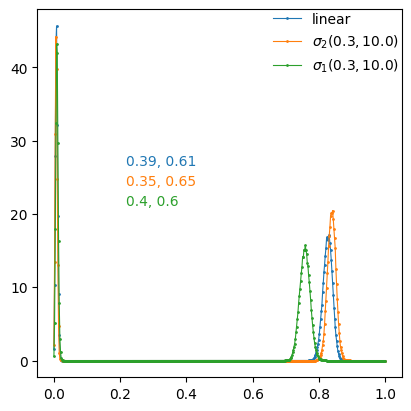

In [82]:
ci_kwargs_list = [[0, ], [2, 0.3, 10.0], [1, 0.3, 10.0]]

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

peaksCut = 0.4
peaksAvg = []
peaksProb = []
fig, ax = plt.subplots(1,1,figsize=(4,4), constrained_layout=True)
for i,(ci_kwargs,cilabel) in enumerate(zip(ci_kwargs_list,species)):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    ssdata_df = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
    fdata = np.array(ssdata_df['f2'])
    hist, bin_edges = np.histogram(fdata, bins=499, range=(0,1.0), density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binWidth = bin_edges[1]-bin_edges[0]
    ln, = ax.plot(bin_centers, hist, marker='.', ms=2, lw=0.8, label=cilabel)
    prob1, ssval1 = sum(hist[bin_centers<0.5]*binWidth), np.average(fdata[fdata<peaksCut])
    prob2, ssval2 = sum(hist[bin_centers>=0.5]*binWidth), np.average(fdata[fdata>=peaksCut])
    fig.text(0.3, 0.6-0.05*i, f'{round(prob1,4)}, {round(prob2,4)}', color=ln.get_color())
    print(prob1, ssval1)
    print(prob2, ssval2)
    print('------')
    peaksAvg.extend([ssval1, ssval2])
    peaksProb.extend([prob1, prob2])
    
fig.legend(frameon=False)


In [83]:
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

sstimes = []
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    fname = f'tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
    times_df = pd.read_csv(f'{resPath}/{fname}')
    sstimes.append(np.average(times_df['tss']))

In [84]:
costF_lin = peaksAvg[1]*peaksProb[1]/np.average(sstimes[0])
costF_sig2 = peaksAvg[3]*peaksProb[3]/np.average(sstimes[1])
costF_sig1 = peaksAvg[5]*peaksProb[5]/np.average(sstimes[2])


chi = costF_sig2/costF_lin
print(chi)
chi = costF_sig1/costF_lin
print(chi)

1.4287752514776648
1.2022908099690812
